In [88]:

from pyfiglet import Figlet

f_f = Figlet(font='slant')
print(f_f.renderText('Its all about AI and crypto now'))

    ______                ____         __                __     ___    ____
   /  _/ /______   ____ _/ / /  ____ _/ /_  ____  __  __/ /_   /   |  /  _/
   / // __/ ___/  / __ `/ / /  / __ `/ __ \/ __ \/ / / / __/  / /| |  / /  
 _/ // /_(__  )  / /_/ / / /  / /_/ / /_/ / /_/ / /_/ / /_   / ___ |_/ /   
/___/\__/____/   \__,_/_/_/   \__,_/_.___/\____/\__,_/\__/  /_/  |_/___/   
                                                                           
                   __                         __                              
  ____ _____  ____/ /  ____________  ______  / /_____     ____  ____ _      __
 / __ `/ __ \/ __  /  / ___/ ___/ / / / __ \/ __/ __ \   / __ \/ __ \ | /| / /
/ /_/ / / / / /_/ /  / /__/ /  / /_/ / /_/ / /_/ /_/ /  / / / / /_/ / |/ |/ / 
\__,_/_/ /_/\__,_/   \___/_/   \__, / .___/\__/\____/  /_/ /_/\____/|__/|__/  
                              /____/_/                                        



## Etherium prediction with Artificial Intelligence (Deep Learning via LSTM Neural Networks)

In [90]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


Importerar dom bibliotek som krävs.

In [93]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

Via API på Coingecko som är en kryptosida har jag laddat med data från 2018-01-01 till 2022-11-08 till en csv-fil som heter "testa_sammanslagen_data.csv

In [94]:
# Läs in data från CSV-filen
data = pd.read_csv("testa_sammanslagen_data.csv")
# Skriver ut den första raden för att se kolumnrubrikerna
print(data.head(0))
# Välj endast kolumnerna 'Date' och 'Price'
data = data.loc[:,['Date','Price']]
# Skriver ut de första fem raderna av den nya dataramen
print(data.head(5))


Empty DataFrame
Columns: [Date, Price]
Index: []
         Date  Price
0  2018-01-01   6345
1  2018-01-02   7155
2  2018-01-03   7879
3  2018-01-04   7959
4  2018-01-05   8199


In [95]:
data.columns
data.head

<bound method NDFrame.head of             Date  Price
0     2018-01-01   6345
1     2018-01-02   7155
2     2018-01-03   7879
3     2018-01-04   7959
4     2018-01-05   8199
...          ...    ...
1767  2022-11-04  17138
1768  2022-11-05  18099
1769  2022-11-06  17908
1770  2022-11-07  17208
1771  2022-11-08  17029

[1772 rows x 2 columns]>

Ovan kan ses att datasettet har 1772 rader och 2 kulumner.

In [96]:
# Ställer in kolumnen 'Date' som index
data = data.set_index('Date')

# Konverterar indexet till ett DateTimeIndex-objekt
data.index = pd.to_datetime(data.index,unit='ns')

# Skriv ut det nya indexet
print(data.index)

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05', '2018-01-06', '2018-01-07', '2018-01-08',
               '2018-01-09', '2018-01-10',
               ...
               '2022-10-30', '2022-10-31', '2022-11-01', '2022-11-02',
               '2022-11-03', '2022-11-04', '2022-11-05', '2022-11-06',
               '2022-11-07', '2022-11-08'],
              dtype='datetime64[ns]', name='Date', length=1772, freq=None)


In [97]:
# Tilldelar strängen 'Price'(2:a kolumnen i datasettet) till variabeln aim
# aim variabeln kan sedan användas för att referera till kolumnen 'Price'

aim='Price'

In [61]:
train_data = data.iloc[:1450]
test_data = data.iloc[1450:]

def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('ETHEREUM', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    ax.xaxis.set_major_locator(plt.MaxNLocator(8)) 

In [62]:
print(train_data)

            Price
Date             
2018-01-01   6345
2018-01-02   7155
2018-01-03   7879
2018-01-04   7959
2018-01-05   8199
...           ...
2021-12-17  35881
2021-12-18  35540
2021-12-19  36382
2021-12-20  35897
2021-12-21  36135

[1450 rows x 1 columns]


In [63]:
print(test_data)

            Price
Date             
2021-12-22  36854
2021-12-23  36282
2021-12-24  37388
2021-12-25  37017
2021-12-26  37523
...           ...
2022-11-04  17138
2022-11-05  18099
2022-11-06  17908
2022-11-07  17208
2022-11-08  17029

[322 rows x 1 columns]


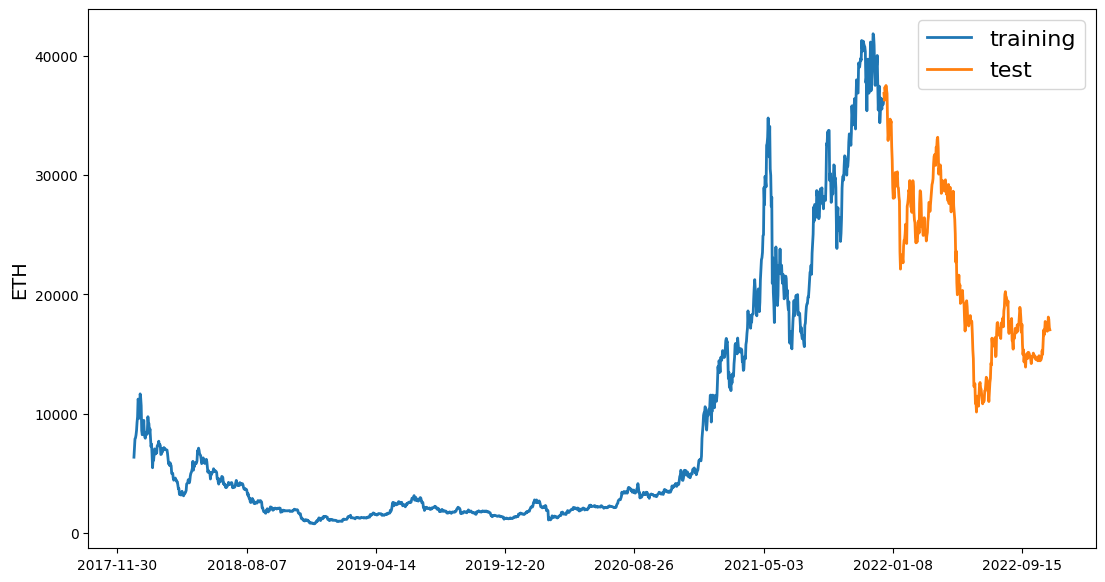

In [64]:
line_plot(train_data[aim], test_data[aim], 'training', 'test', title='')

In [8]:
def normalise_zero_base(continuous):
    return continuous / continuous.iloc[0] - 1

def normalise_min_max(continuous):
    return (continuous - continuous.min()) / (data.max() - continuous.min())

In [9]:

def extract_window_data(continuous, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(continuous) - window_len):
        tmp = continuous[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)
def prepare_data(aim, window_len=10, zero_base=True):
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[aim][window_len:].values
    y_test = test_data[aim][window_len:].values
    if zero_base:
        y_train = y_train / train_data[aim][:-window_len].values - 1
        y_test = y_test / test_data[aim][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [10]:

def build_lstm_model(input_data, output_size, neurons, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model
np.random.seed(245)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 50
epochs = 40
batch_size = 32
loss = 'mse'
dropout = 0.24
optimizer = 'adam'
train_data, test_data, X_train, X_test, y_train, y_test = prepare_data(
    data, aim, window_len=window_len, zero_base=zero_base, test_size=test_size)
     

#### print(X_train.shape), nedan, kommer visa de faktiska dimensionerna på  träningsdatan och ge en uppfattning om storleken på träningsdatan. Detta är användbart för att kontrollera att datan har rätt form och storlek innan den matas in i  modellen.

In [11]:
print(X_train.shape)

(1445, 5, 1)


## (1445, 5, 1) betyder följande:

Det finns totalt 1445 tidsfönster.
Varje tidsfönster har 5 tidssteg.
Varje tidssteg har 1 funktion (variabel).
Jag har 1445 exempel av tidssekvensdata för träning, där varje exempel består av en sekvens av 5 tidssteg, och varje tidssteg innehåller endast en variabel.

Detta är den form man förväntar sig att träningsdata ska ha för att matas in i en LSTM-modell. Varje tidsfönster representerar en sekvens av datapunkter över tid, och LSTM-modellen kommer att träna på dessa sekvenser för att göra förutsägelser.

In [12]:
# Bygger LSTM-modellen med de specificerade parametrarna
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)

# Tränar modellen med träningsdata och validerar den med testdata
modelfit = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)
     

Epoch 1/40


/mnt/c/Users/aras/python_iths/iths_2023_sep_dec/aras_venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.0118 - val_loss: 0.0046
Epoch 2/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0057 - val_loss: 0.0040
Epoch 3/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - val_loss: 0.0032
Epoch 4/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0043 - val_loss: 0.0028
Epoch 5/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0040 - val_loss: 0.0026
Epoch 6/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0036 - val_loss: 0.0023
Epoch 7/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0032 - val_loss: 0.0021
Epoch 8/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 9/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 10/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 11/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 12/40
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0031 - val_loss: 0.0018

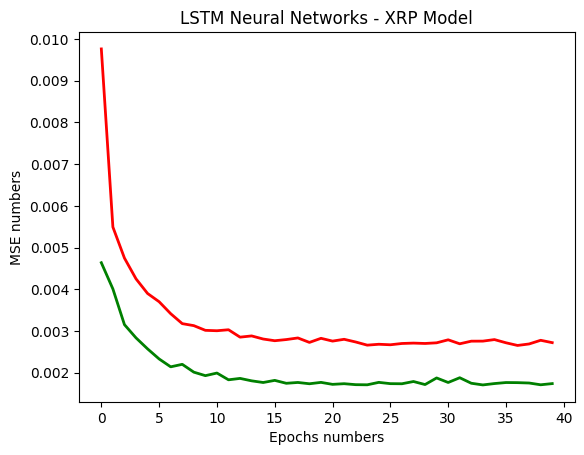

In [13]:
plt.plot(modelfit.history['loss'],'r',linewidth=2, label='Training loss')
plt.plot(modelfit.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM Neural Networks - XRP Model')
plt.xlabel('Epochs numbers')
plt.ylabel('MSE numbers')
plt.show()

Medelabsolutfelet (MAE) mellan modellens förutsägelser och de verkliga målen. Detta är ett vanligt sätt att utvärdera en regressionsmodells prestanda.

In [14]:
#Skapa en serie 'targets' som innehåller de verkliga målen från testdatan 'test_data'
targets = test_data[aim][window_len:]
#Använder den tränade modellen för att göra förutsägelser på testdatan X_test. "squeeze" (flattar) ut resultaten till en endimensionell array.
preds = model.predict(X_test).squeeze()
#Beräknar medelvärdet av absolutvärdet av skillnaden mellan förutsägelserna preds och de verkliga målen y_test. Detta ger MAE mellan modellens förutsägelser och de verkliga målen på testdatan.
mean_absolute_error(preds, y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


0.031413610460935035

medelkvadratfelet (MSE=mean squared error) mellan modellens förutsägelser och de verkliga målen på testdatan. MSE är en annan vanlig måttstock för att utvärdera prestanda hos en regressionsmodell, och det mäter genomsnittet av kvadraten på skillnaden mellan varje förutsagt värde och det faktiska värdet.

Det är en bra praxis att använda både MSE och MAE för att utvärdera prestanda hos en regressionsmodell, eftersom de båda ger olika aspekter av modellens fel. MSE ger mer vikt åt stora fel på grund av kvadreringen, medan MAE ger en bättre uppfattning om genomsnittlig absolut felstorlek.

In [15]:
#Beräknar medelvärdet av kvadraten av skillnaden mellan varje element i preds (modellens förutsägelser) och motsvarande element i 
# y_test (de verkliga målen på testdatan). Detta ger dig MSE mellan modellens förutsägelser och de verkliga målen.
from sklearn.metrics import mean_squared_error
SCORE_MSE=mean_squared_error(preds, y_test)
SCORE_MSE

0.0017443539980952648

R2-score, förklaringsgraden, är ett användbart verktyg för att bedöma modellens prestanda. R2-score är ett mått på hur väl den beroende variabeln förklaras av den oberoende variabeln i modellen. Det ger en indikation på hur bra modellen passar dina data jämfört med en enkel genomsnittsmodell.

In [16]:
from sklearn.metrics import r2_score
r2_score=r2_score(y_test, preds)
r2_score*100

81.74715510589638

[37658.06014585 37364.65028358 37011.82946014 34764.34917444
 33034.94286847 33514.65603292 33462.17682159 34288.1079728
 34874.03646922 34557.74614561 34665.49742746 32721.0880909
 31368.18326283 29169.35276091 28037.10325015 28501.65912473
 28204.43741059 29355.8627491  30368.01185608 29363.80899239
 29942.51642108 30213.66953182 30420.20879388 29252.8095423
 29004.84268665 28359.01366019 27912.1828866  24010.18187582
 22091.47608161 23010.02924591 22711.88801479 22889.14033556
 23091.70565557 22781.11616224 24055.95816302 24697.99231529
 24763.51068115 25194.3977952  25987.53816843 24991.19007444
 24375.49353254 27264.33008528 27885.25886917 28179.60299611
 28850.49449444 28775.80295801 29633.86396575 28949.54591274
 27567.09252644 27304.19091201 26960.96579432 27574.7122246
 29576.25438166 29315.32480669 27183.06106448 26295.57820195
 26015.05869216 24884.39697051 24373.65821743 24683.68234849
 24493.195274   24773.84905243 26087.47559559 26358.18484426
 25356.7194351  27562.798708

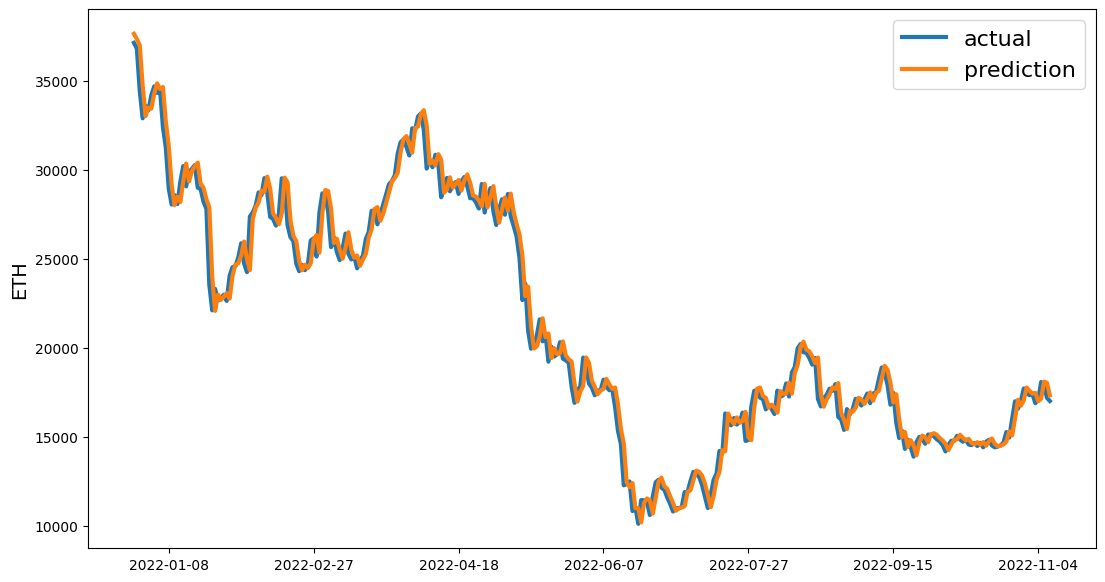

In [17]:
preds = test_data[aim].values[:-window_len] * (preds + 1)
print(preds)  
preds = pd.Series(index=targets.index, data=preds)
print(preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [18]:
print(targets.index[-1])

2022-11-08 00:00:00


In [19]:
print(preds.index[-1])

2022-11-08 00:00:00


In [70]:
antal_dagar = 5
# Lägg till en dag till det sista datumet
future_date = targets.index[-1] + pd.Timedelta(days=antal_dagar)

In [71]:
print(future_date)

2022-11-13 00:00:00


In [84]:
import pandas as pd

# Antal dagar att lägga till
antal_dagar = 5

# Omvandla `targets` till ett pandas datetime-index om det inte redan är det
targets = pd.to_datetime(targets)

# Beräkna det framtida datumet
future_date = targets.index[-1] + pd.Timedelta(days=antal_dagar)

# Gör en förutsägelse för det framtida datumet
future_prediction = model.predict(future_date)

print("Framtida förutsägelse för priset:", future_prediction)





ValueError: Unrecognized data type: x=2022-11-13 00:00:00 (of type <class 'pandas._libs.tslibs.timestamps.Timestamp'>)

In [82]:
print(future_date)

2022-11-13 00:00:00


In [72]:
future_prediction = model.predict(X_test[-1:])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


In [73]:
print(future_prediction)

[[0.02577447]]


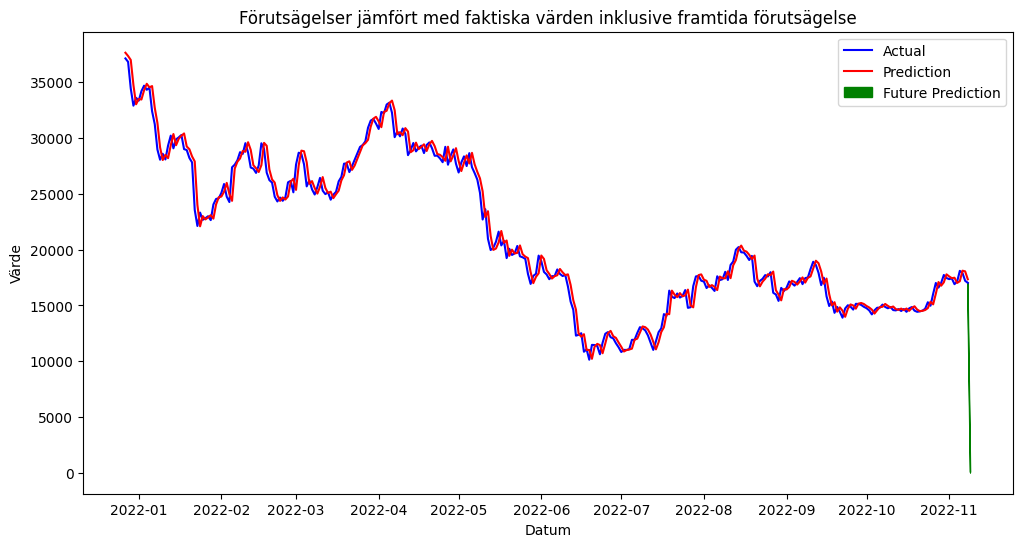

In [42]:
import pandas as pd
import matplotlib.pyplot as plt


# Skapa en pandas Series för framtida förutsägelse
future_prediction_series = pd.Series(index=[future_date], data=future_prediction.flatten())

# Plot förutsägelser och målvariabler
plt.figure(figsize=(12, 6))
plt.plot(targets.index, targets, label='Actual', color='blue')  # faktiska värden
plt.plot(preds.index, preds, label='Prediction', color='red')  # förutsägelser

# Plotta också future_prediction
#plt.plot(future_prediction_series.index, future_prediction_series, 'ro', label='Future Prediction')  # framtida förutsägelse

# Plotta en pil för att visa den framtida förutsägelsen
plt.arrow(targets.index[-1], targets.iloc[-1], 1, future_prediction_series.values[0] - targets.iloc[-1], 
width=0.1, head_width=0.3, head_length=0.2, color='green', label='Future Prediction')

# Ställ in etiketter och titel
plt.xlabel('Datum')
plt.ylabel('Värde')
plt.title('Förutsägelser jämfört med faktiska värden inklusive framtida förutsägelse')
plt.legend()

# Visa plotten
plt.show()







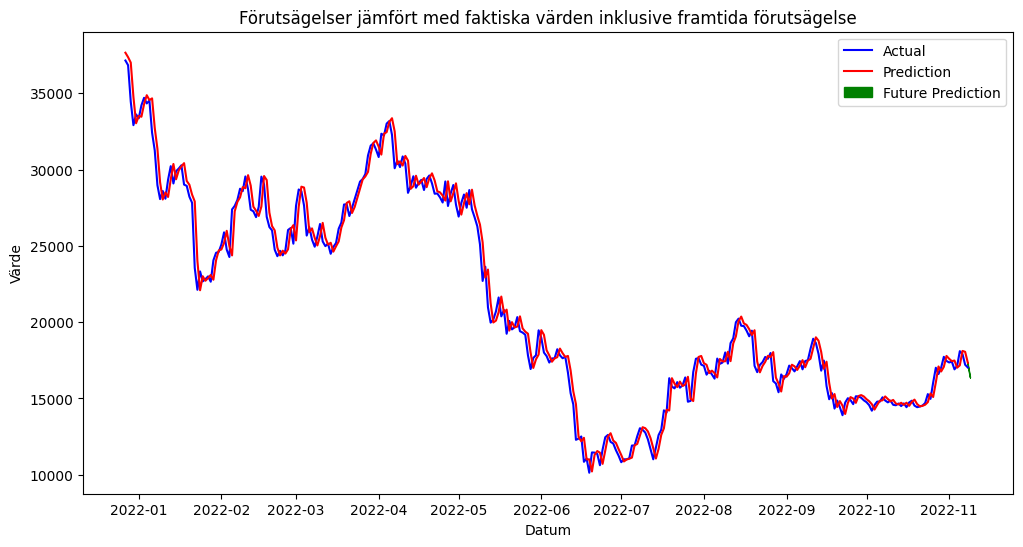

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

# Lägg till en dag till det sista datumet
future_date = targets.index[-1] + pd.Timedelta(days=1)

# Skapa en pandas Series för framtida förutsägelse
future_prediction_series = pd.Series(index=[future_date], data=future_prediction.flatten())

# Plot förutsägelser och målvariabler
plt.figure(figsize=(12, 6))
plt.plot(targets.index, targets, label='Actual', color='blue')  # faktiska värden
plt.plot(preds.index, preds, label='Prediction', color='red')  # förutsägelser

# Bestäm startpositionen för pilen (där förutsägelsen slutar)
start_x = preds.index[-1]
start_y = preds.iloc[-1]

# Bestäm slutpositionen för pilen (en viss längd ner på y-axeln från startpositionen)
end_x = start_x + pd.Timedelta(days=1)
#end_y = start_y + pd.Timedelta(days=1)
end_y = start_y - 1000.0  # Justera detta värde för att ändra längden på pilen

# Plotta pilen för att visa den framtida förutsägelsen
plt.arrow(start_x, start_y, 1, end_y - start_y, 
          width=0.1, head_width=0.3, head_length=0.2, color='green', label='Future Prediction')

# Ställ in etiketter och titel
plt.xlabel('Datum')
plt.ylabel('Värde')
plt.title('Förutsägelser jämfört med faktiska värden inklusive framtida förutsägelse')
plt.legend()

# Visa plotten
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


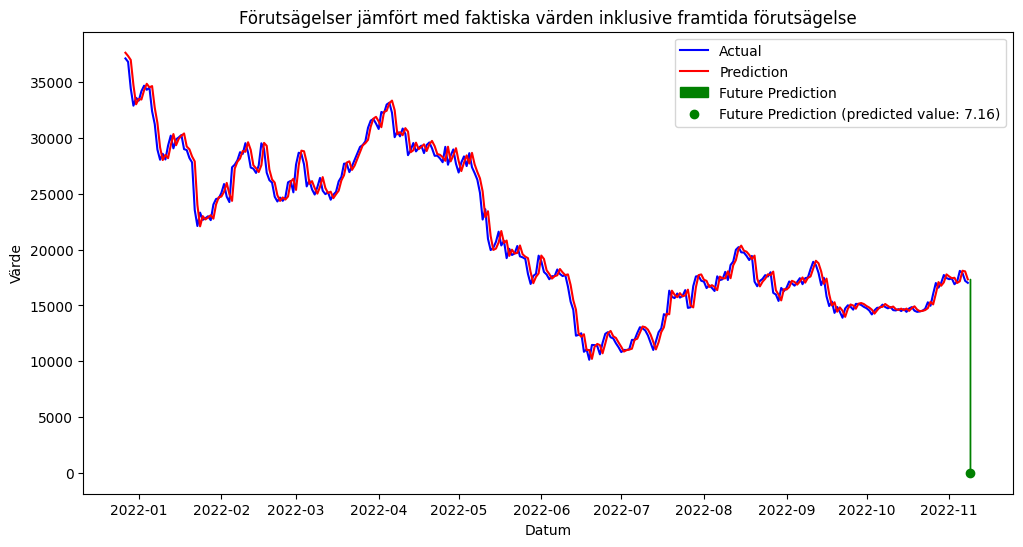

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Lägg till en dag till det sista datumet för att få det framtida datumet
future_date = targets.index[-1] + pd.Timedelta(days=1)

# Omvandla tidstämpeln till ett numeriskt värde (t.ex. Unix-timestamp)
future_date_numeric = future_date.timestamp()

# Använd modellen för att göra en förutsägelse för det framtida y-värdet
future_prediction = model.predict(np.array([[future_date_numeric]]).reshape(1, 1, 1))

# Plot förutsägelser och målvariabler
plt.figure(figsize=(12, 6))
plt.plot(targets.index, targets, label='Actual', color='blue')  # faktiska värden
plt.plot(preds.index, preds, label='Prediction', color='red')  # förutsägelser

# Plotta en pil för att visa den framtida förutsägelsen
plt.arrow(future_date, preds[-1], 0, future_prediction[0][0] - preds[-1], 
          width=0.1, head_width=0.3, head_length=0.2, color='green', label='Future Prediction')

# Skriv ut den förutsagda framtida punkten
plt.scatter(future_date, future_prediction[0][0], color='green', label=f'Future Prediction (predicted value: {future_prediction[0][0]:.2f})')

# Ställ in etiketter och titel
plt.xlabel('Datum')
plt.ylabel('Värde')
plt.title('Förutsägelser jämfört med faktiska värden inklusive framtida förutsägelse')
plt.legend()

# Visa plotten
plt.show()











In [54]:
import pandas as pd
import numpy as np

def get_predicted_x_for_date(model, input_date, test_data, aim, window_len):
    # Omvandla datumet till det format som modellen förväntar sig
    input_timestamp = pd.Timestamp(input_date)
    input_numeric = input_timestamp.timestamp()
    
    # Förutsäg x-värdet för det angivna datumet med modellen
    input_data = np.array([[input_numeric]]).reshape(1, 1, 1)
    predicted_y = model.predict(input_data)
    
    # Beräkna det förutsagda x-värdet baserat på det förutsagda y-värdet
    predicted_x = (test_data[aim].values[-window_len] * (predicted_y + 1)).squeeze()
    
    return predicted_x

# Användning av funktionen
input_date = '2020-04-10'
predicted_x_value = get_predicted_x_for_date(model, input_date, test_data, aim, window_len)
print("Förutsagt x-värde för datumet", input_date, "är:", predicted_x_value)



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Förutsagt x-värde för datumet 2020-04-10 är: 139764.3
